# Linear Sequential Estimation

In [8]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1)

In [9]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Generate sample time series data

In [10]:
t = np.linspace(0, 6, 500)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Add some normal (gaussian) noise

In [11]:
# Example for Gaussian (normal) random variable

noise_mean = 0
noise_std = 0.5

v = np.column_stack(np.random.normal(noise_mean, noise_std, len(y))).T

In [12]:
y_tilde = y+v

# Plotting

<Axes: xlabel='Time', ylabel='y'>

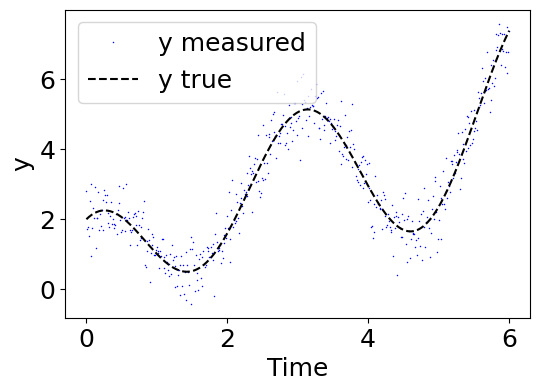

In [13]:
plot_tme(t, y, y_tilde)

# Candidate models

In [14]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Exercise

Implement Linear Sequential Estimation, and plot the three parameters of $x$ over time

In [14]:
def kalman_update_equation(x_k, y_k1, P_k, W_k1, H_k1):
  P_k1_inv = np.invert(P_k)+H_k1.T@W_k1@H_k1
  k_k1 = np.invert(P_k1_inv)@H_k1.T@W_k1

  x_k1 = x_k + k_k1@(y_k1 - H_k1@x_k)

  return x_k1, P_k1_inv

In [ ]:
W = np.eye(len(model_1_H))
for t in range(200):
  if t == 0:
    x_k =
    p_k = 10 * np.eye(len(W))
  y_k = y_tilde[t]
  x_k, P_k = kalman_update_equation(x_k, y_k, P_k, W, )